In [1]:
%reload_ext autoreload
%autoreload 2
import os
import time
from absl import logging
from typing import Any
from functools import partial

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.training import train_state
import optax

import tensorflow as tf
import tensorflow_datasets as tfds

from ml_collections import ConfigDict

%cd /hildafs/projects/phy230056p/junzhez/AI/maskgit/gmmg
%ls

# Import custom modules
from src.loss import l2_loss
from src.vqvae import VQVAE

2024-05-30 00:38:03.782652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/hildafs/projects/phy230056p/junzhez/AI/maskgit/gmmg
config/                   layers.ipynb  src/               train_token.ipynb
image_editing_test.ipynb  nets.ipynb    tf_datasets.ipynb


/hildafs/projects/phy230056p/junzhez/.conda/envs/AI_torch/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Data (we do not need label)

In [2]:
# Directory to save images
data_dir = '/hildafs/projects/phy230056p/junzhez/data/'
data_name = 'mnist'
save_dir = os.path.join(data_dir, data_name)
os.makedirs(save_dir, exist_ok=True)

# Load MNIST dataset using TensorFlow Datasets
dataset_name = 'mnist'
train_split = 'train[:80%]'
val_split = 'train[80%:]'
test_split = 'test'

train_dataset, train_info = tfds.load(dataset_name, data_dir=save_dir, split=train_split, with_info=True)
val_dataset = tfds.load(dataset_name, data_dir=save_dir, split=val_split)
test_dataset = tfds.load(dataset_name, data_dir=save_dir, split=test_split)

# Preprocess dataset
def preprocess(sample):
    image = sample['image']
    image = tf.cast(image, tf.float32) / 255.0
    return {'image': image}

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Convert to numpy arrays and batch the data
batch_size = 256
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

2024-05-30 00:38:12.054061: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2024-05-30 00:38:16.541521: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-30 00:38:16.588049: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-30 00:38:16.622417: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. I

shape = (batch, height, width, channels)
Train data shape: (256, 28, 28, 1)
Val data shape: (256, 28, 28, 1)
Test data shape: (256, 28, 28, 1)


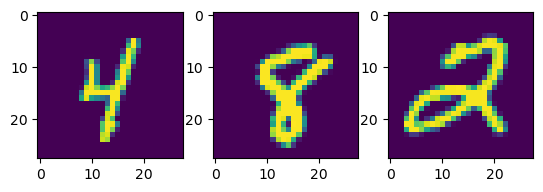

In [3]:
# example training, validation, and test data
train_example = next(iter(train_dataset.as_numpy_iterator()))
val_example = next(iter(val_dataset.as_numpy_iterator()))
test_example = next(iter(test_dataset.as_numpy_iterator()))

print('shape = (batch, height, width, channels)')
print(f"Train data shape: {train_example['image'].shape}")
print(f"Val data shape: {val_example['image'].shape}")
print(f"Test data shape: {test_example['image'].shape}")

# plot example data
fig, axs = plt.subplots(1, 3)
axs[0].imshow(train_example['image'][0])
axs[1].imshow(val_example['image'][0])
axs[2].imshow(test_example['image'][0])
plt.show()

# Config

In [4]:
# Create the VQVAE model configuration
config = ConfigDict()
config.vqvae = ConfigDict()

# encoder configs
config.vqvae.filters = 64
config.vqvae.num_res_blocks = 2
config.vqvae.channel_multipliers = [1, 1, 2]
config.vqvae.embedding_dim = 32 # output dimension of the encoder
config.vqvae.conv_downsample = False # whether to use convolutional downsampling or average pooling downsampling in the encoder/decoder
config.vqvae.conv_fn = "conv" # the standard convolutional layer in the residual block, and in the encoder (flax.linen.Conv)
config.vqvae.norm_type = "GN" # normalization layer in the residual block, default to group norm so we don't need to keep track of running statistics
config.vqvae.activation_fn = "swish" # activation function in the residual block, and in the encoder

# additional decoder configs
config.vqvae.output_dim = 1 # N of decoder output channels = N color channels 

# quantizer configs
config.vqvae.codebook_size = 256
config.vqvae.commitment_cost = 0.25

# quantizer's entropy loss configs
config.vqvae.entropy_loss_ratio = 0.1
config.vqvae.entropy_temperature = 0.01
config.vqvae.entropy_loss_type = "softmax"

# Training

In [5]:
# Define arrays to store training and validation losses
train_losses = []
val_losses = []

# Define the model
model = VQVAE(config=config, train=True, dtype=jnp.float32)

# Initialize parameters
input_sample = next(iter(train_dataset.as_numpy_iterator()))['image']
params = model.init(jax.random.PRNGKey(0), {'image': input_sample})

# Setup optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer,
)

# Define the loss function
def loss_fn(params, batch):
    image = batch['image']
    reconstructed, result_dict = model.apply(params, {'image': image})
    reconstruction_loss = jnp.mean((reconstructed - image) ** 2)
    quantizer_loss = result_dict['quantizer_loss']
    total_loss = quantizer_loss + reconstruction_loss
    return total_loss, (reconstructed, result_dict)

# Define the training step
@jax.jit
def train_step(state, batch):
    (loss, (reconstructed, result_dict)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss, reconstructed, result_dict

2024-05-30 00:38:24.211709: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_epoch_losses = []
    for batch in train_dataset.as_numpy_iterator():
        state, loss, reconstructed, result_dict = train_step(state, batch)
        train_epoch_losses.append(loss)
    train_epoch_losses = jnp.array(train_epoch_losses)
    train_losses.append(jnp.mean(train_epoch_losses))

    # Validation
    val_epoch_losses = []
    model_train = VQVAE(config=config, train=False, dtype=jnp.float32)
    for batch in val_dataset.as_numpy_iterator():
        loss, _ = loss_fn(state.params, batch)
        val_epoch_losses.append(loss)
    val_epoch_losses = jnp.array(val_epoch_losses)
    val_losses.append(jnp.mean(val_epoch_losses))
    print(f'Epoch {epoch}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')


2024-05-30 00:38:53.062393: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce-window.912 = f32[256,14,14,64]{3,2,1,0} reduce-window(f32[256,28,28,64]{3,2,1,0} %broadcast.573, f32[] %constant.599), window={size=1x2x2x1 stride=1x2x2x1}, to_apply=%region_9.908, metadata={op_name="jit(train_step)/jit(main)/jvp(VQVAE)/VQVAE.encode/encoder/reduce_window_sum[window_dimensions=(1, 2, 2, 1) window_strides=(1, 2, 2, 1) padding=((0, 0), (0, 0), (0, 0), (0, 0)) base_dilation=(1, 1, 1, 1) window_dilation=(1, 1, 1, 1)]" source_file="/hildafs/projects/phy230056p/junzhez/AI/maskgit/gmmg/src/layer.py" source_line=73}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, 

Epoch 0, Training Loss: -0.21332918107509613, Validation Loss: -0.2680032551288605


2024-05-30 00:39:43.485323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 00:39:53.932572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Training Loss: -0.32129502296447754, Validation Loss: -0.36499494314193726


2024-05-30 00:39:59.142898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 00:40:09.301129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Training Loss: -0.39181914925575256, Validation Loss: -0.41376757621765137


2024-05-30 00:40:14.506878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 00:40:24.756652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Training Loss: -0.4303267300128937, Validation Loss: -0.442901074886322


2024-05-30 00:40:29.969346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 00:40:40.509770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Training Loss: -0.45257237553596497, Validation Loss: -0.46225473284721375


2024-05-30 00:40:45.704810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 00:40:56.327438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Training Loss: -0.4663124084472656, Validation Loss: -0.47009041905403137


2024-05-30 00:41:01.554603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 00:41:12.261334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6, Training Loss: -0.47598162293434143, Validation Loss: -0.48317378759384155


2024-05-30 00:41:17.479042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 00:41:27.985635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Training Loss: -0.4832973778247833, Validation Loss: -0.48553547263145447


2024-05-30 00:41:33.192233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 00:41:43.555486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Training Loss: -0.4880788028240204, Validation Loss: -0.4952790439128876


2024-05-30 00:41:48.783408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9, Training Loss: -0.4937426745891571, Validation Loss: -0.49648168683052063


2024-05-30 00:41:59.496555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


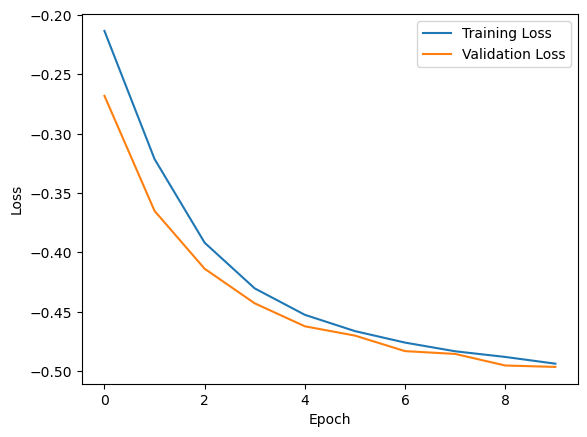

In [7]:
# plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### checkpointing
- https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html

In [18]:
from orbax.checkpoint import CheckpointManager, CheckpointManagerOptions, PyTreeCheckpointer
from flax.training import orbax_utils
ckpt_dir = '/hildafs/projects/phy230056p/junzhez/AI/maskgit/gmmg/ckpt'

# Create a PyTreeCheckpointer
checkpointer = PyTreeCheckpointer()

# Setup CheckpointManager with options
options = CheckpointManagerOptions(create=True, max_to_keep=3, keep_period=2)
checkpoint_manager = CheckpointManager(ckpt_dir, checkpointer, options)

checkpoint_manager.save(num_epochs, state)

True

In [ ]:
restore_args = flax.training.orbax_utils.restore_args_from_target(TARGET_PYTREE, mesh=None)
ckpt_mgr.restore(4, items=TARGET_PYTREE, restore_kwargs={'restore_args': restore_args})

# Evaluation

2024-05-30 00:46:56.198060: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


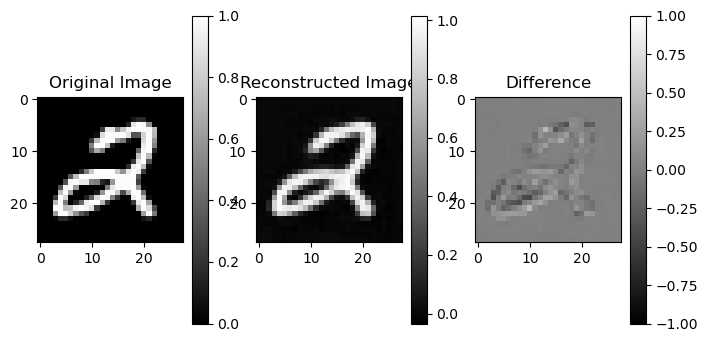

In [17]:
# Function to process a single image
def process_single_image(image, params):
    # Expand dims to add batch dimension
    input_dict = {'image': jnp.expand_dims(image, axis=0)}
    # Properly apply the model
    reconstructed, _ = model_eval.apply(params, input_dict)
    # Remove batch dimension for display
    return jnp.squeeze(reconstructed)

# Load a single test image for demonstration
test_image = next(iter(test_dataset.as_numpy_iterator()))['image'][0]

# Initialize model for evaluation
model_eval = VQVAE(config=config, train=False, dtype=jnp.float32)

# Process the single test image
reconstructed_image = process_single_image(test_image, state.params)

# Visualize the result
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
c = plt.imshow(test_image.squeeze(), cmap='gray')
plt.colorbar(c)
plt.title('Original Image')
plt.subplot(1, 3, 2)
c = plt.imshow(reconstructed_image, cmap='gray')
plt.colorbar(c)
plt.title('Reconstructed Image')
# show the difference between the original and reconstructed images
plt.subplot(1, 3, 3)
c = plt.imshow(test_image.squeeze() - reconstructed_image, cmap='gray', vmin=-1, vmax=1)
plt.colorbar(c)
plt.title('Difference')
plt.show()

### restore from orbax checkpoint, and evaluate the restored state


In [28]:
from orbax.checkpoint import CheckpointManager, CheckpointManagerOptions, PyTreeCheckpointer
from flax.training import orbax_utils
ckpt_dir = '/hildafs/projects/phy230056p/junzhez/AI/maskgit/gmmg/ckpt'

checkpointer = PyTreeCheckpointer()

# Setup CheckpointManager with options
options = CheckpointManagerOptions(create=False, max_to_keep=3, keep_period=2)
checkpoint_manager = CheckpointManager(ckpt_dir, checkpointer, options)

# If you know the specific step you want to restore
step_to_restore = 10 
restored_state = checkpoint_manager.restore(step_to_restore)
print(restored_state.keys())
restored_state = restored_state['params']

/hildafs/projects/phy230056p/junzhez/.conda/envs/AI_torch/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1401: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


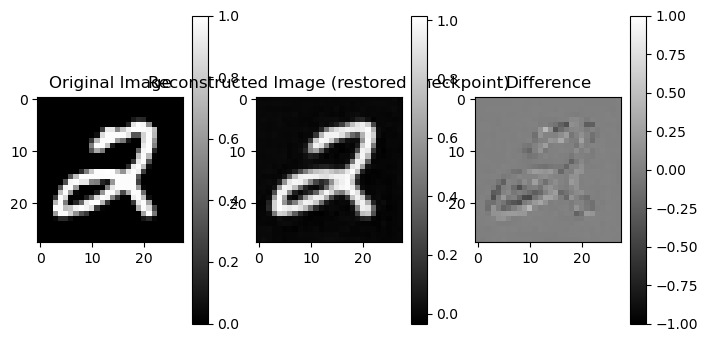

In [34]:
# Initialize model for evaluation
model_eval = VQVAE(config=config, train=False, dtype=jnp.float32)

# Process the single test image
reconstructed_image = process_single_image(test_image, restored_state)

# Visualize the result
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
c = plt.imshow(test_image.squeeze(), cmap='gray')
plt.colorbar(c)
plt.title('Original Image')
plt.subplot(1, 3, 2)
c = plt.imshow(reconstructed_image, cmap='gray')
plt.colorbar(c)
plt.title('Reconstructed Image (restored checkpoint)')
# show the difference between the original and reconstructed images
plt.subplot(1, 3, 3)
c = plt.imshow(test_image.squeeze() - reconstructed_image, cmap='gray', vmin=-1, vmax=1)
plt.colorbar(c)
plt.title('Difference')
plt.show()

# Training

In [ ]:
# Define the model
model = VQVAE(config=config, train=True, dtype=jnp.float32)

# Initialize parameters
input_sample = next(iter(train_dataset.as_numpy_iterator()))['image']
params = model.init(init_rng, {'image': input_sample})

# Setup optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer,
)

# Define the loss function
def loss_fn(params, batch):
    image = batch['image']
    reconstructed, result_dict = model.apply(params, {'image': image})
    reconstruction_loss = jnp.mean((reconstructed - image) ** 2)
    quantizer_loss = result_dict['quantizer_loss']
    total_loss = quantizer_loss + reconstruction_loss
    return total_loss, (reconstructed, result_dict)

# Define the training step
@jax.jit
def train_step(state, batch):
    (loss, (reconstructed, result_dict)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss, reconstructed, result_dict

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_dataset.as_numpy_iterator():
        state, loss, reconstructed, result_dict = train_step(state, batch)
        print(f'Epoch {epoch}, Loss: {loss}')

# Save the model parameters if necessary
# jax.jax.save('/path/to/save/model_params.pkl', state.params)

2024-05-29 23:22:55.860030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


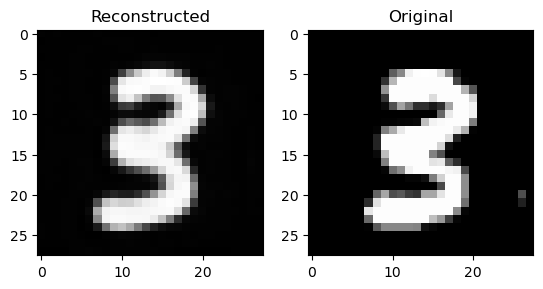

In [21]:
# Evaluate on the validation set
model_eval = VQVAE(config=config, train=False, dtype=jnp.float32)
for batch in val_dataset.as_numpy_iterator():
    reconstructed, result_dict = model_eval.apply(state.params, batch)
    # Visualization or calculation of validation metrics here

# Visualize some results
fig, axs = plt.subplots(1, 2)
axs[0].imshow(reconstructed[0], cmap='gray')
axs[0].title.set_text('Reconstructed')
axs[1].imshow(batch['image'][0], cmap='gray')
axs[1].title.set_text('Original')
plt.show()
